**Master IASD 2025**

Deep Learning for Image Analisis

Practical Session: Oct 24-2025

You should submit the notebook with the answers be email before the deadline.

Deadline: Oct 31-2025

Santiago VELASCO-FORERO santiago.velasco@minesparis.psl.eu

An **autoencoder** is a type of artificial neural network used for unsupervised learning. Its primary goal is to learn a compressed, efficient representation (encoding) of input data, and then reconstruct the original data from this encoding. Autoencoders are widely used for tasks like dimensionality reduction, anomaly detection, image denoising, and feature extraction.

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.64MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.2MB/s]


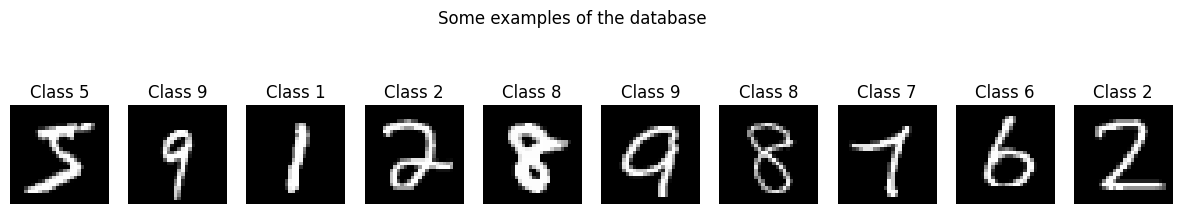

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 32
learning_rate = 1e-3
num_epochs = 24
latent_dim = 2

# MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


# Plot one example per class
def plot_examples_per_class(dataset, num_classes=10):
    fig, axes = plt.subplots(1, num_classes, figsize=(15, 3))
    for i in range(num_classes):
        img, label = dataset[i * 600]  # Pick one example per class
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(f"Class {label}")
        axes[i].axis('off')
    plt.suptitle("Some examples of the database")
    plt.show()

plot_examples_per_class(train_dataset)


In [2]:
# Function to add noise to MNIST images
def add_noise(img):
    noise = torch.randn(img.size()).to(device) * 0.2
    noisy_img = img + noise
    return torch.clamp(noisy_img, 0., 1.)

# Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def forward_two(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded,encoded

# Denoising Autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def forward_two(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded,encoded

# Variational Autoencoder
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc21 = nn.Linear(128, latent_dim)  # mu
        self.fc22 = nn.Linear(128, latent_dim)  # logvar
        self.fc3 = nn.Linear(latent_dim, 128)
        self.fc4 = nn.Linear(128, 28*28)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)  # mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        x = x.view(x.size(0), -1)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def forward_two(self, x):
        x = x.view(x.size(0), -1)
        mu, logvar = self.encode(x)
        #z = self.reparameterize(mu, logvar)
        return self.decode(mu), mu #, logvar


# Function to compute validation loss
def compute_val_loss(model, val_loader, criterion, is_vae=False):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            img, _ = data
            img = img.view(img.size(0), -1).to(device)
            if is_vae:
                recon_batch, mu, logvar = model(img)
                val_loss += loss_function(recon_batch, img, mu, logvar).item()
            else:
                output = model(img)
                val_loss += criterion(output, img).item()
    return val_loss / len(val_loader.dataset)

# Function to train the autoencoder and save history
def train_autoencoder(model, train_loader, val_loader, num_epochs=num_epochs):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            img, _ = data
            img = img.view(img.size(0), -1).to(device)

            # Forward pass
            output = model(img)
            loss = criterion(output, img)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average training loss for the epoch
        train_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # Compute validation loss
        val_loss = compute_val_loss(model, val_loader, criterion)
        history['val_loss'].append(val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Plot an example
        example_img = next(iter(val_loader))[0][0].to(device)
        plot_example(model, example_img, f"(Epoch {epoch+1})")

    return model, history

# Function to train the denoising autoencoder and save history
def train_denoising_autoencoder(model, train_loader, val_loader, num_epochs=num_epochs):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            img, _ = data
            img = img.view(img.size(0), -1).to(device)
            noisy_img = add_noise(img).to(device)  # Move noisy_img to the same device

            # Forward pass
            output = model(noisy_img)
            loss = criterion(output, img)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average training loss for the epoch
        train_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # Compute validation loss
        val_loss = compute_val_loss(model, val_loader, criterion)
        history['val_loss'].append(val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Plot an example
        example_img = next(iter(val_loader))[0][0].to(device)
        plot_example(model, example_img, f"(Epoch {epoch+1})")
    return model, history



# Function to train the VAE and save history
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train_vae(model, train_loader, val_loader, num_epochs=num_epochs):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            img, _ = data
            img = img.view(img.size(0), -1).to(device)

            # Forward pass
            recon_batch, mu, logvar = model(img)
            loss = loss_function(recon_batch, img, mu, logvar)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average training loss for the epoch
        train_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # Compute validation loss
        val_loss = compute_val_loss(model, val_loader, None, is_vae=True)
        history['val_loss'].append(val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Plot an example
        example_img = next(iter(val_loader))[0][0].to(device)
        plot_example(model, example_img, f"(Epoch {epoch+1})", is_vae=True)

    return model, history

# Function to plot loss history
def plot_loss_history(history, title):
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# Function to plot input and output images
def plot_example(model, img, title, is_vae=False):
    model.eval()
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)  # Add batch dimension and move to device
        if is_vae:
            recon_batch, _, _ = model(img)
            output = recon_batch
        else:
            output = model(img)
        img = img.squeeze().view(28, 28).cpu().numpy()
        output = output.squeeze().view(28, 28).cpu().numpy()

        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.title(f"Input {title}")
        plt.imshow(img, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f"Output {title}")
        plt.imshow(output, cmap='gray')
        plt.axis('off')
        plt.show()

**Reparametrization trick**

Suppose $q_\phi(z)=N(\mu_{\phi},\sigma^2_{\phi}I)$.

The standard approach is to reparameterize $z$ as follows: $z=\mu_{\phi}+\sigma_{\phi}\odot\epsilon$, where $\epsilon \sim N(0,I)$. In this case, $\epsilon$ is independent of $\phi$.

The expectation becomes
$\mathbb{E}_{z \sim q_{\phi}(z)} (f(z))= \mathbb{E}_{\epsilon\sim N(0,I)}[f(\mu_{\phi}+\sigma_{\phi}\odot \epsilon)]$

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        x = x.view(x.size(0), -1)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [3]:
# Initialize models
autoencoder = Autoencoder(latent_dim).to(device)
denosing_autoencoder = DenoisingAutoencoder(latent_dim).to(device)
vae = VAE(latent_dim).to(device)


Training Autoencoder...
Epoch [1/24], Train Loss: 0.0017, Val Loss: 0.0015


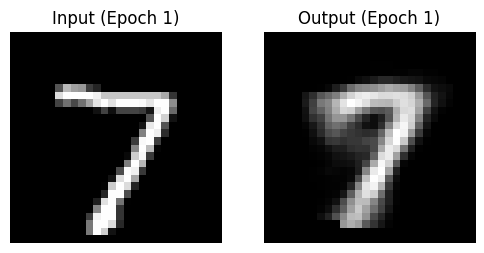

Epoch [2/24], Train Loss: 0.0015, Val Loss: 0.0014


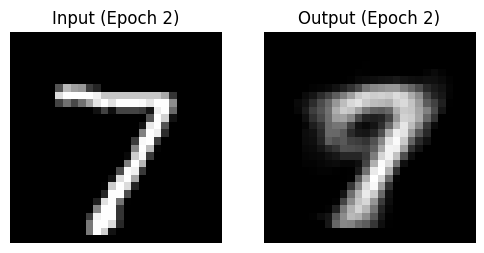

Epoch [3/24], Train Loss: 0.0014, Val Loss: 0.0014


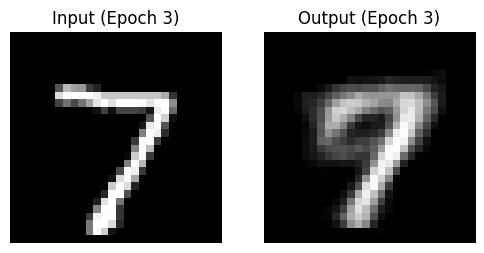

Epoch [4/24], Train Loss: 0.0014, Val Loss: 0.0014


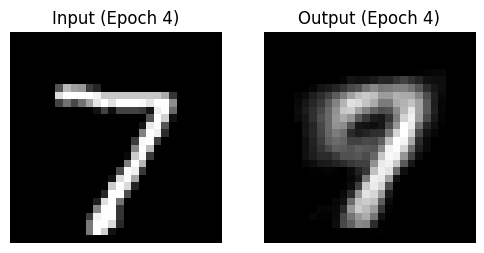

Epoch [5/24], Train Loss: 0.0014, Val Loss: 0.0014


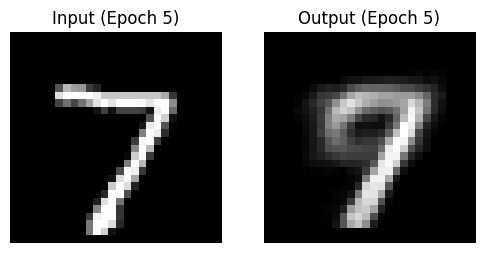

Epoch [6/24], Train Loss: 0.0013, Val Loss: 0.0013


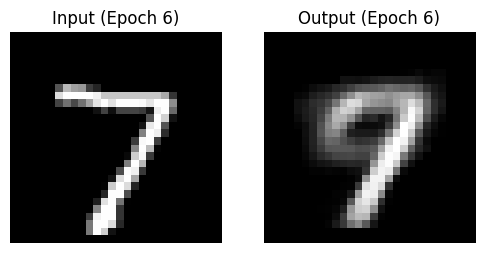

Epoch [7/24], Train Loss: 0.0013, Val Loss: 0.0013


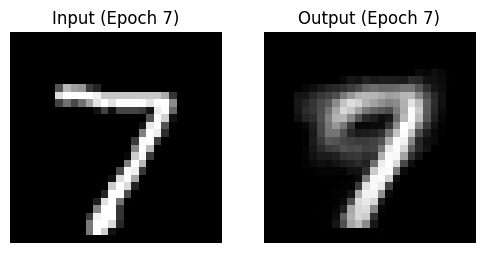

Epoch [8/24], Train Loss: 0.0013, Val Loss: 0.0013


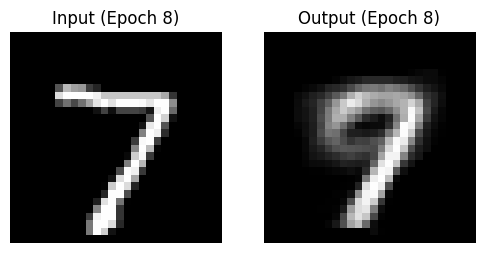

Epoch [9/24], Train Loss: 0.0013, Val Loss: 0.0013


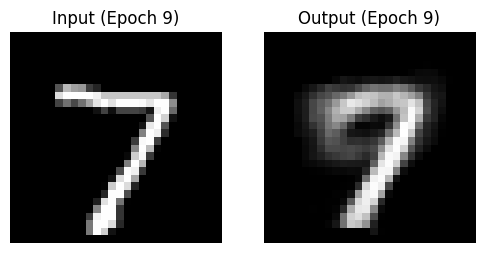

Epoch [10/24], Train Loss: 0.0013, Val Loss: 0.0013


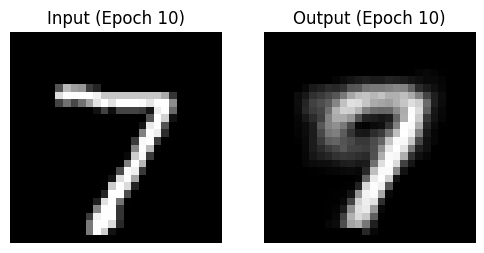

Epoch [11/24], Train Loss: 0.0013, Val Loss: 0.0013


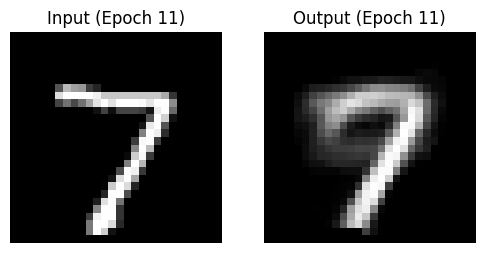

Epoch [12/24], Train Loss: 0.0013, Val Loss: 0.0013


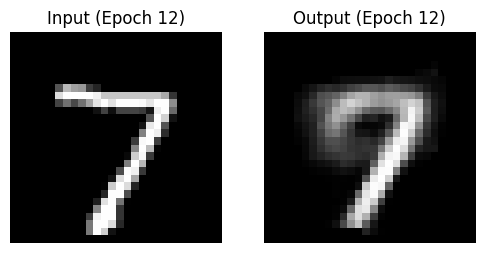

Epoch [13/24], Train Loss: 0.0013, Val Loss: 0.0013


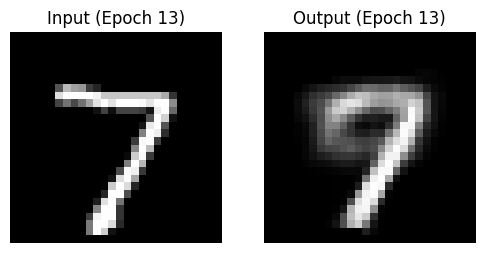

Epoch [14/24], Train Loss: 0.0013, Val Loss: 0.0013


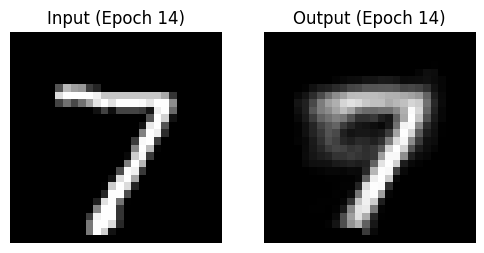

Epoch [15/24], Train Loss: 0.0013, Val Loss: 0.0013


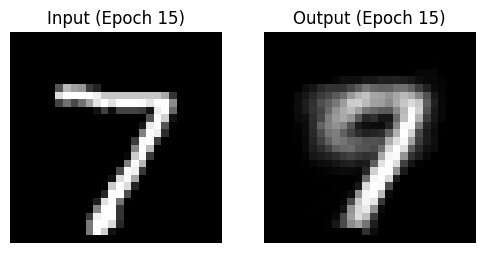

Epoch [16/24], Train Loss: 0.0013, Val Loss: 0.0013


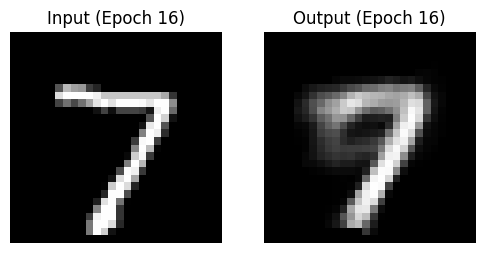

Epoch [17/24], Train Loss: 0.0013, Val Loss: 0.0013


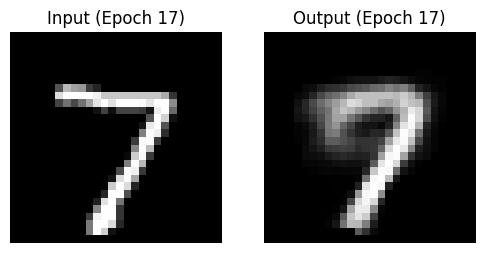

Epoch [18/24], Train Loss: 0.0013, Val Loss: 0.0013


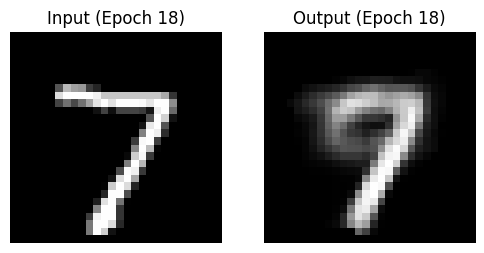

Epoch [19/24], Train Loss: 0.0012, Val Loss: 0.0013


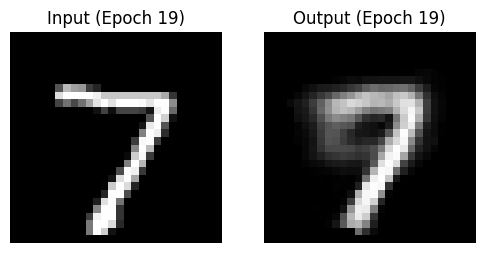

Epoch [20/24], Train Loss: 0.0012, Val Loss: 0.0013


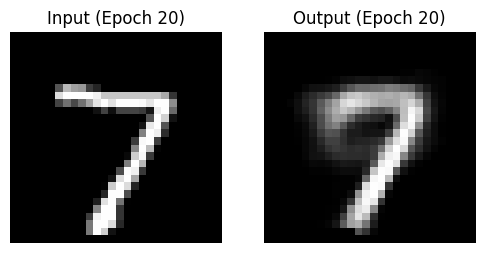

Epoch [21/24], Train Loss: 0.0012, Val Loss: 0.0013


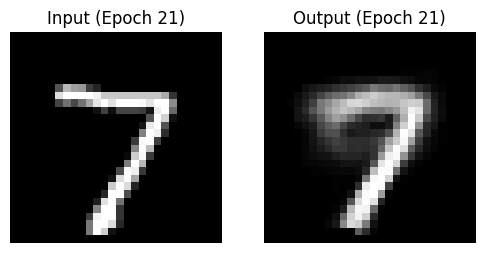

Epoch [22/24], Train Loss: 0.0012, Val Loss: 0.0013


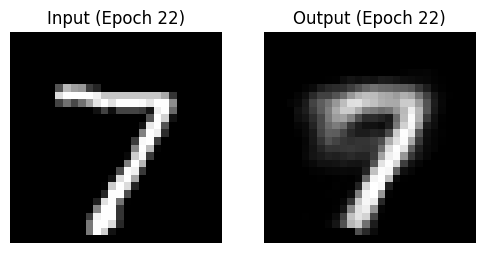

Epoch [23/24], Train Loss: 0.0012, Val Loss: 0.0013


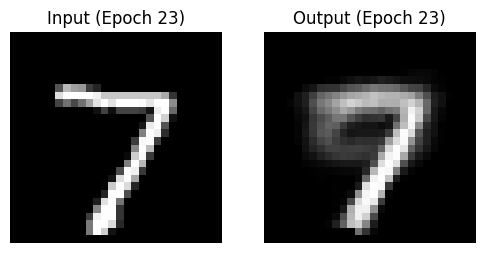

Epoch [24/24], Train Loss: 0.0012, Val Loss: 0.0013


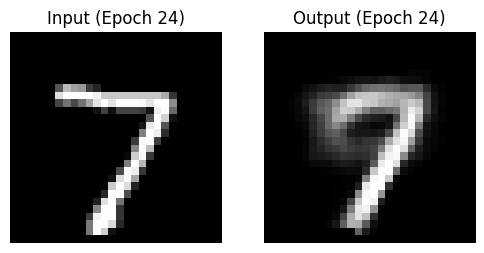

In [4]:
# Train models and save history
print("Training Autoencoder...")
trained_autoencoder, ae_history = train_autoencoder(autoencoder, train_loader, val_loader)




Training Denoising Autoencoder...
Epoch [1/24], Train Loss: 0.0017, Val Loss: 0.0016


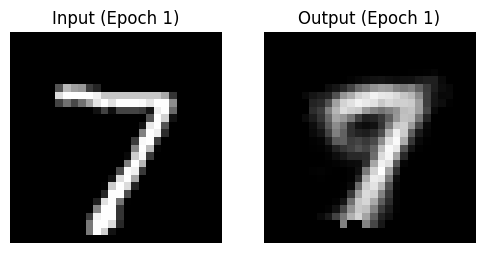

Epoch [2/24], Train Loss: 0.0015, Val Loss: 0.0015


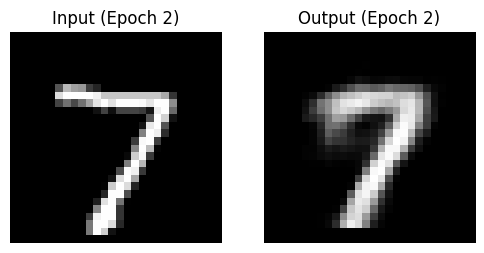

Epoch [3/24], Train Loss: 0.0014, Val Loss: 0.0015


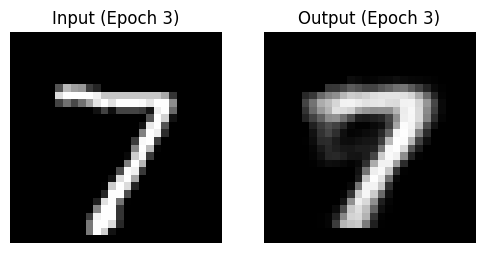

Epoch [4/24], Train Loss: 0.0014, Val Loss: 0.0015


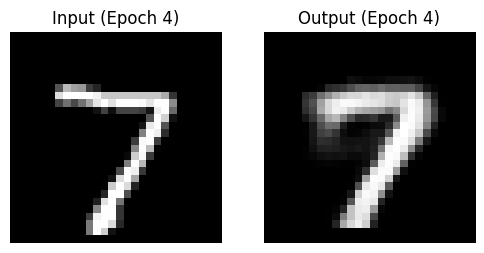

Epoch [5/24], Train Loss: 0.0014, Val Loss: 0.0015


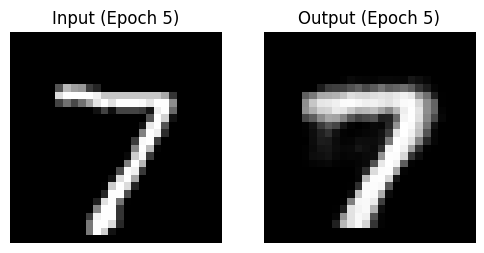

Epoch [6/24], Train Loss: 0.0013, Val Loss: 0.0014


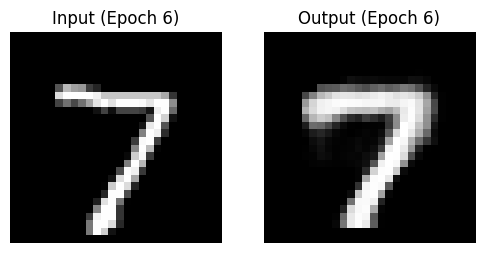

Epoch [7/24], Train Loss: 0.0013, Val Loss: 0.0014


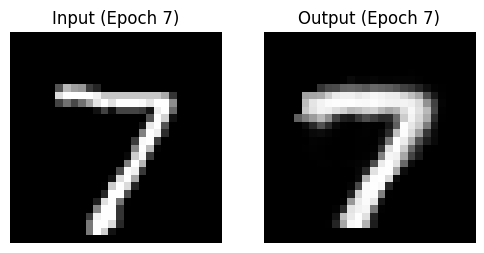

Epoch [8/24], Train Loss: 0.0013, Val Loss: 0.0014


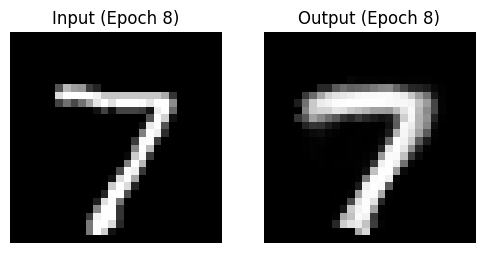

Epoch [9/24], Train Loss: 0.0013, Val Loss: 0.0014


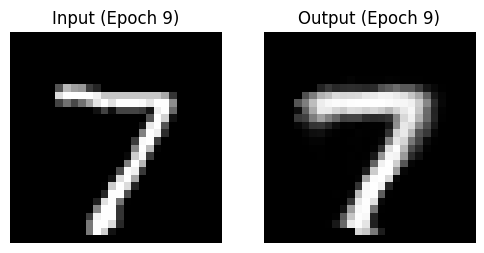

Epoch [10/24], Train Loss: 0.0013, Val Loss: 0.0014


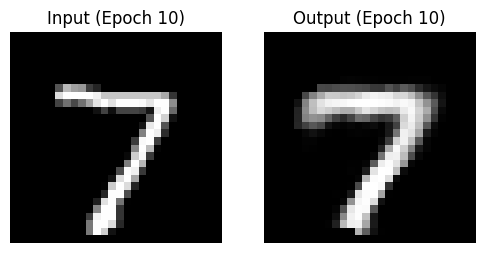

Epoch [11/24], Train Loss: 0.0013, Val Loss: 0.0014


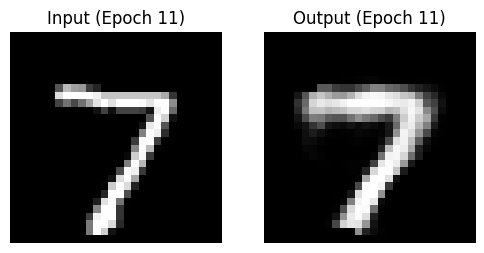

Epoch [12/24], Train Loss: 0.0013, Val Loss: 0.0014


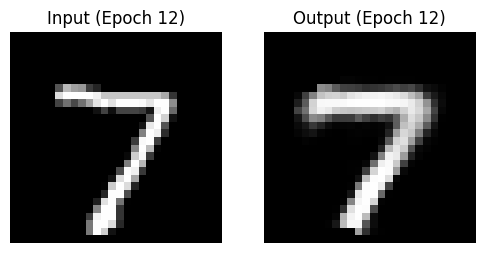

Epoch [13/24], Train Loss: 0.0013, Val Loss: 0.0014


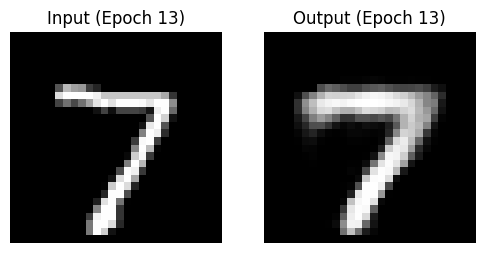

Epoch [14/24], Train Loss: 0.0013, Val Loss: 0.0014


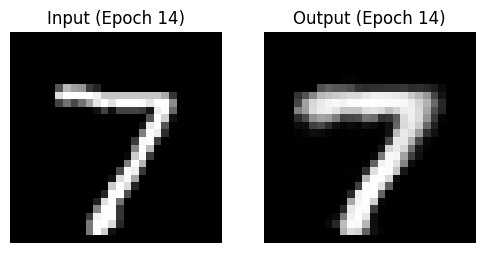

Epoch [15/24], Train Loss: 0.0013, Val Loss: 0.0014


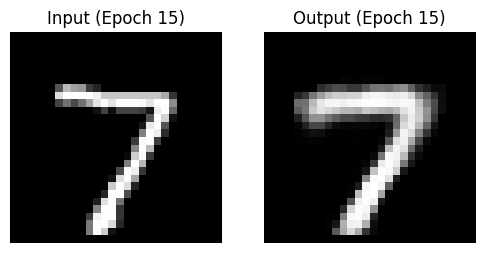

Epoch [16/24], Train Loss: 0.0013, Val Loss: 0.0014


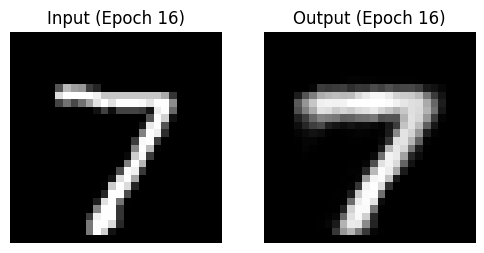

Epoch [17/24], Train Loss: 0.0013, Val Loss: 0.0014


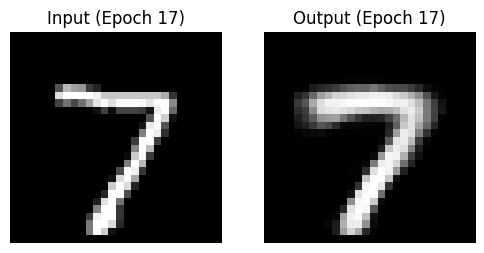

Epoch [18/24], Train Loss: 0.0013, Val Loss: 0.0014


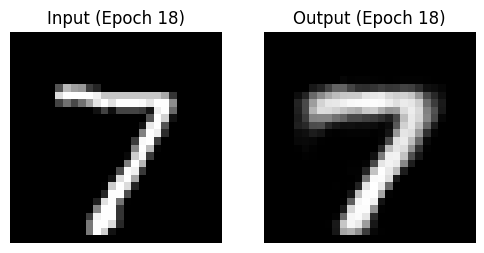

Epoch [19/24], Train Loss: 0.0013, Val Loss: 0.0014


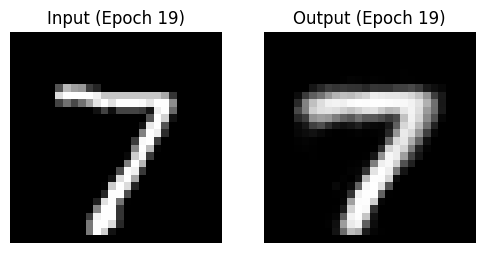

Epoch [20/24], Train Loss: 0.0013, Val Loss: 0.0014


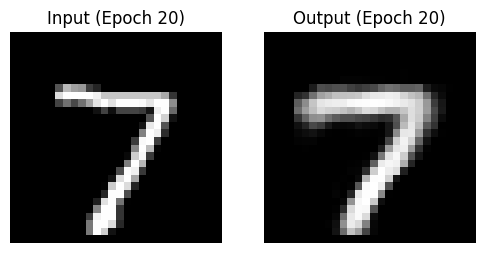

Epoch [21/24], Train Loss: 0.0013, Val Loss: 0.0014


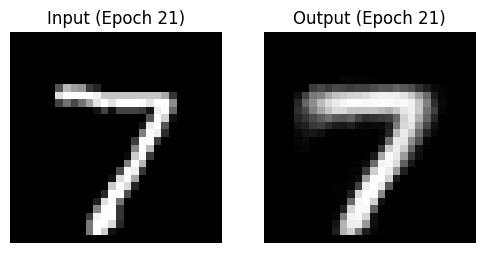

Epoch [22/24], Train Loss: 0.0013, Val Loss: 0.0014


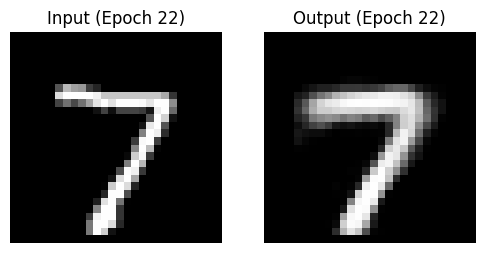

Epoch [23/24], Train Loss: 0.0013, Val Loss: 0.0014


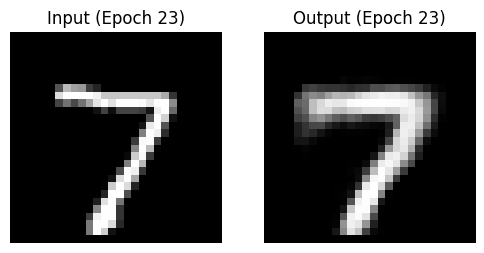

Epoch [24/24], Train Loss: 0.0013, Val Loss: 0.0014


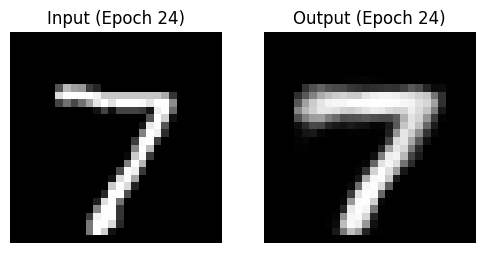

In [5]:
print("\nTraining Denoising Autoencoder...")
trained_denoising_autoencoder, dae_history = train_denoising_autoencoder(denosing_autoencoder, train_loader, val_loader)



Training Variational Autoencoder...
Epoch [1/24], Train Loss: 183.2426, Val Loss: 168.4197


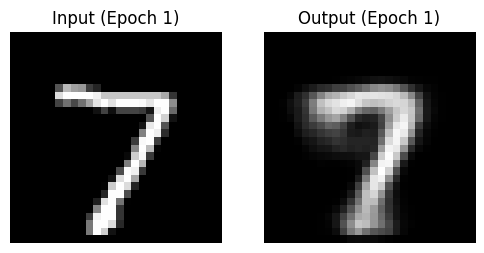

Epoch [2/24], Train Loss: 166.2094, Val Loss: 163.9474


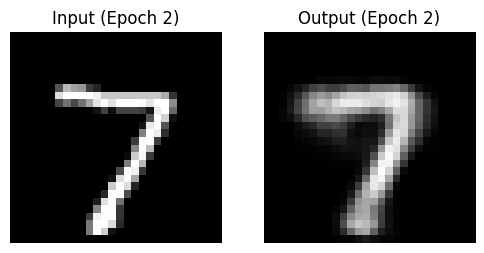

Epoch [3/24], Train Loss: 163.0850, Val Loss: 161.5689


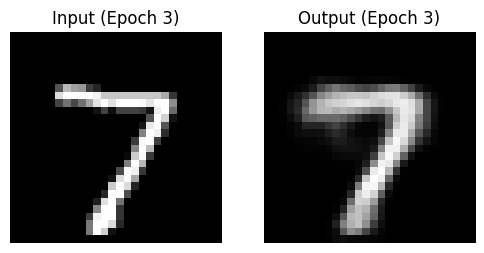

Epoch [4/24], Train Loss: 161.0702, Val Loss: 159.6339


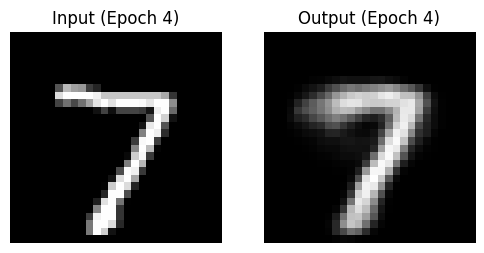

Epoch [5/24], Train Loss: 159.3328, Val Loss: 157.9795


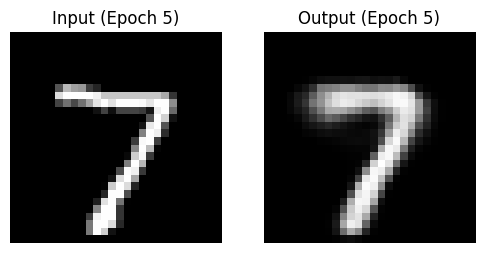

Epoch [6/24], Train Loss: 157.8073, Val Loss: 156.9753


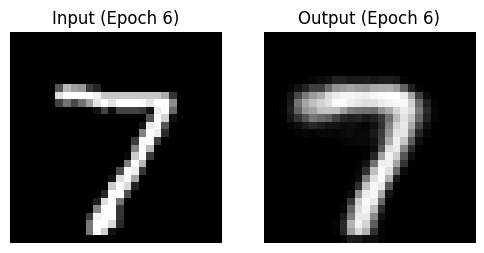

Epoch [7/24], Train Loss: 156.6059, Val Loss: 156.2171


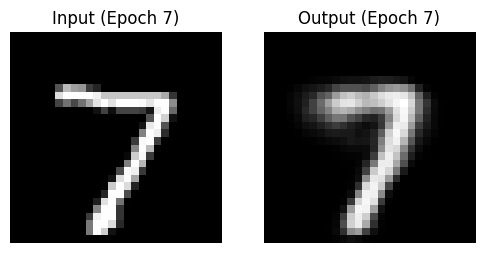

Epoch [8/24], Train Loss: 155.6628, Val Loss: 155.2262


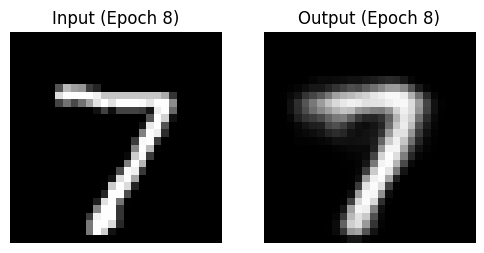

Epoch [9/24], Train Loss: 154.9701, Val Loss: 154.7076


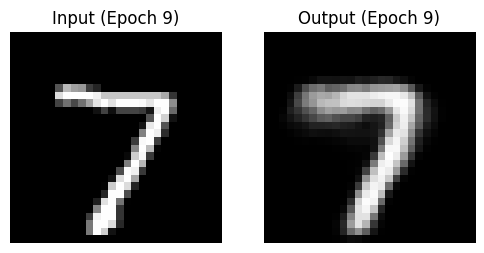

Epoch [10/24], Train Loss: 154.3884, Val Loss: 154.3468


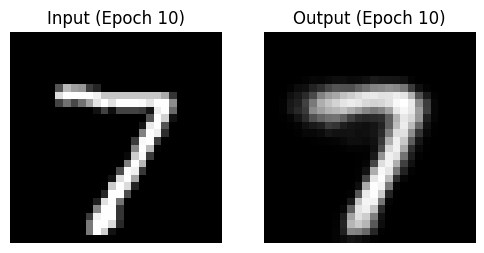

Epoch [11/24], Train Loss: 153.9044, Val Loss: 153.8482


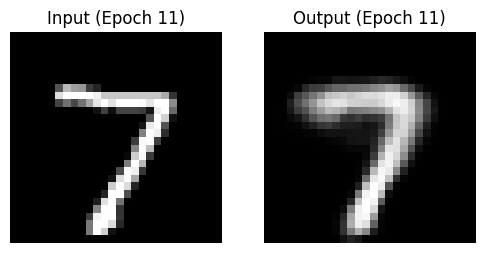

Epoch [12/24], Train Loss: 153.4581, Val Loss: 153.4352


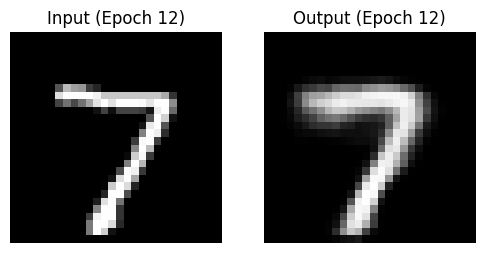

Epoch [13/24], Train Loss: 153.0865, Val Loss: 152.9203


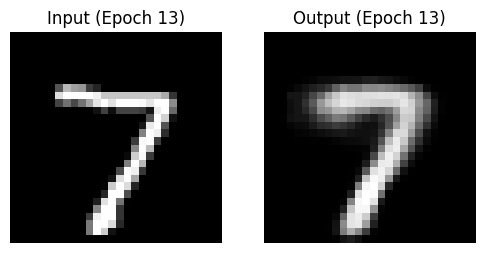

Epoch [14/24], Train Loss: 152.7691, Val Loss: 152.9784


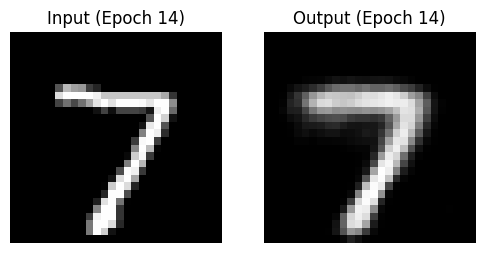

Epoch [15/24], Train Loss: 152.4334, Val Loss: 152.9255


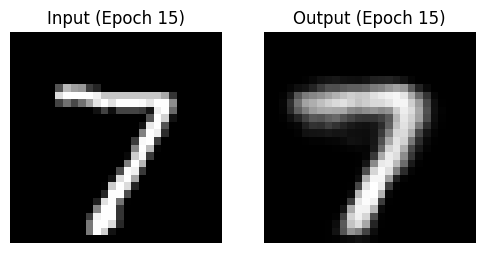

Epoch [16/24], Train Loss: 152.1906, Val Loss: 152.7107


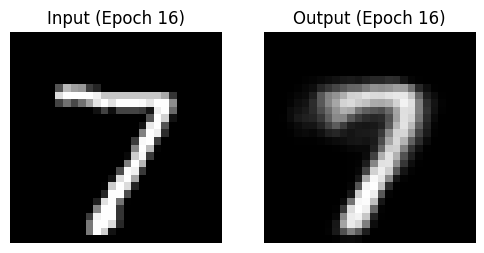

Epoch [17/24], Train Loss: 151.9681, Val Loss: 152.2192


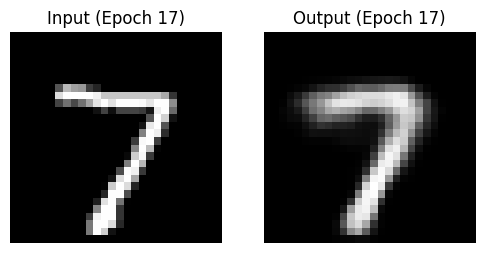

Epoch [18/24], Train Loss: 151.6951, Val Loss: 152.8084


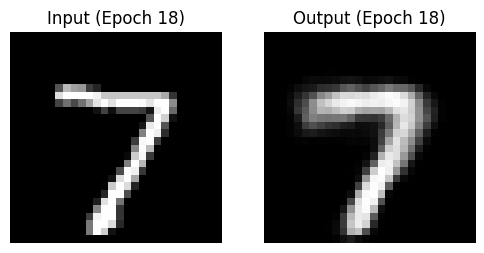

Epoch [19/24], Train Loss: 151.4675, Val Loss: 152.1374


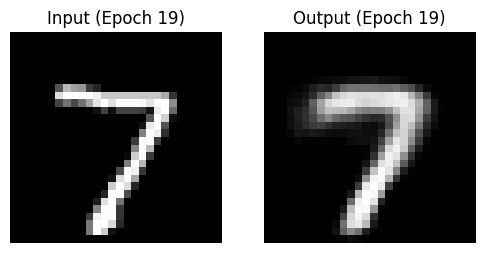

Epoch [20/24], Train Loss: 151.2634, Val Loss: 151.6695


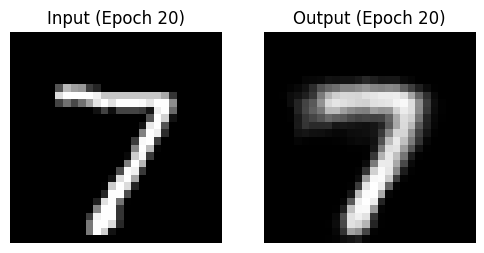

Epoch [21/24], Train Loss: 151.0573, Val Loss: 151.5136


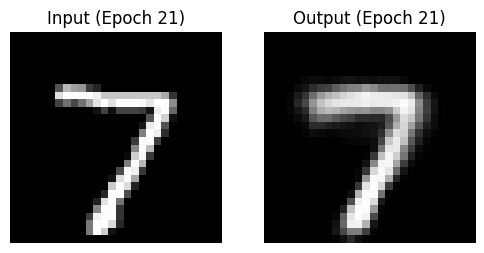

Epoch [22/24], Train Loss: 150.8764, Val Loss: 151.7964


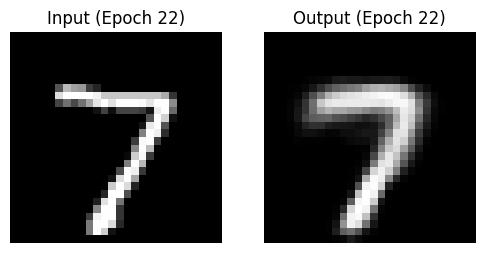

Epoch [23/24], Train Loss: 150.6725, Val Loss: 151.5840


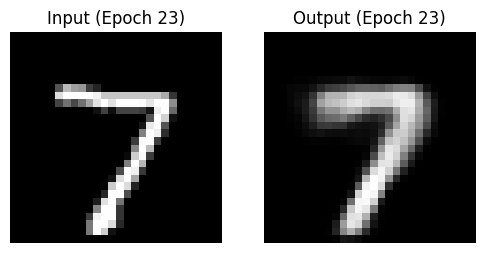

Epoch [24/24], Train Loss: 150.4901, Val Loss: 151.6423


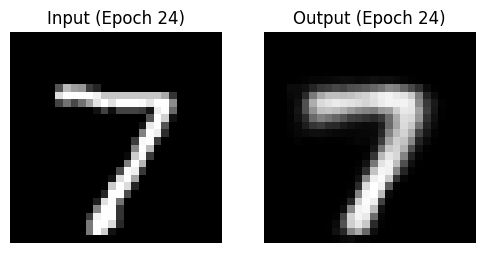

In [6]:

print("\nTraining Variational Autoencoder...")
trained_vae, vae_history = train_vae(vae, train_loader, val_loader)


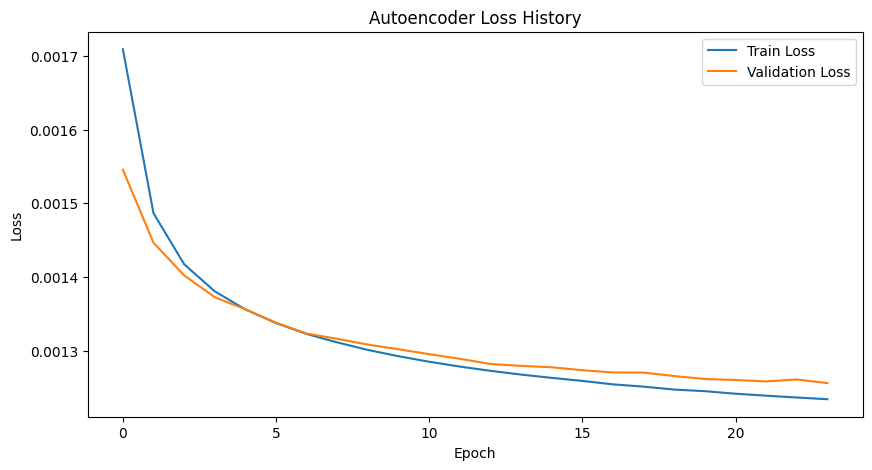

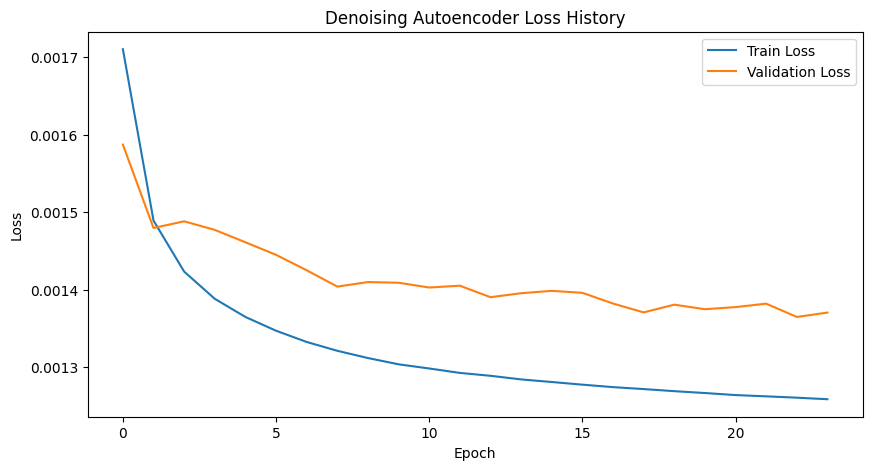

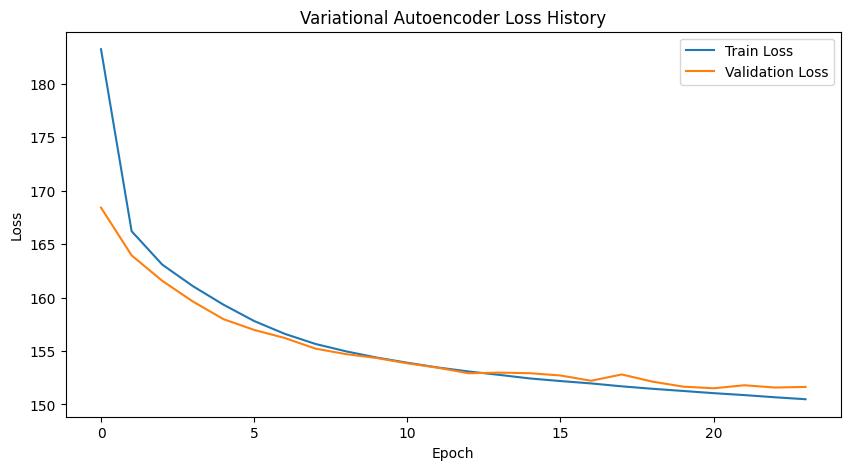

In [7]:

# Plot loss history
plot_loss_history(ae_history, 'Autoencoder Loss History')
plot_loss_history(dae_history, 'Denoising Autoencoder Loss History')
plot_loss_history(vae_history, 'Variational Autoencoder Loss History')



In [8]:
def extract_latent_representations(model, data_loader):
    model.eval()
    latent_reps = []
    labels = []
    with torch.no_grad():
        for data in data_loader:
            img, label = data
            img = img.to(device)
            img = img.view(img.size(0), -1)  # Flatten
            output = model.forward_two(img)
            #print("Model output type:", type(output), "length:", len(output))  # Debugging line
            decoded, encoded = output
            latent_reps.append(encoded.cpu().numpy())
            labels.append(label.numpy())
    return np.concatenate(latent_reps), np.concatenate(labels)



In [9]:
latent_reps, labels = extract_latent_representations(trained_autoencoder, train_loader)

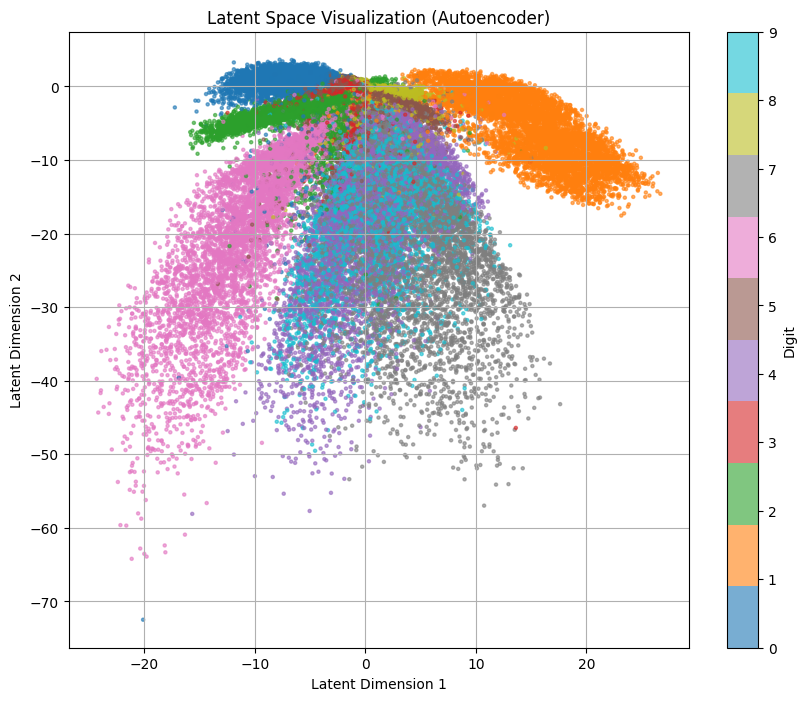

In [10]:
# Plot the latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_reps[:, 0], latent_reps[:, 1], c=labels, cmap='tab10', alpha=0.6, s=5)
plt.colorbar(scatter, ticks=range(10), label='Digit')
plt.title('Latent Space Visualization (Autoencoder)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()

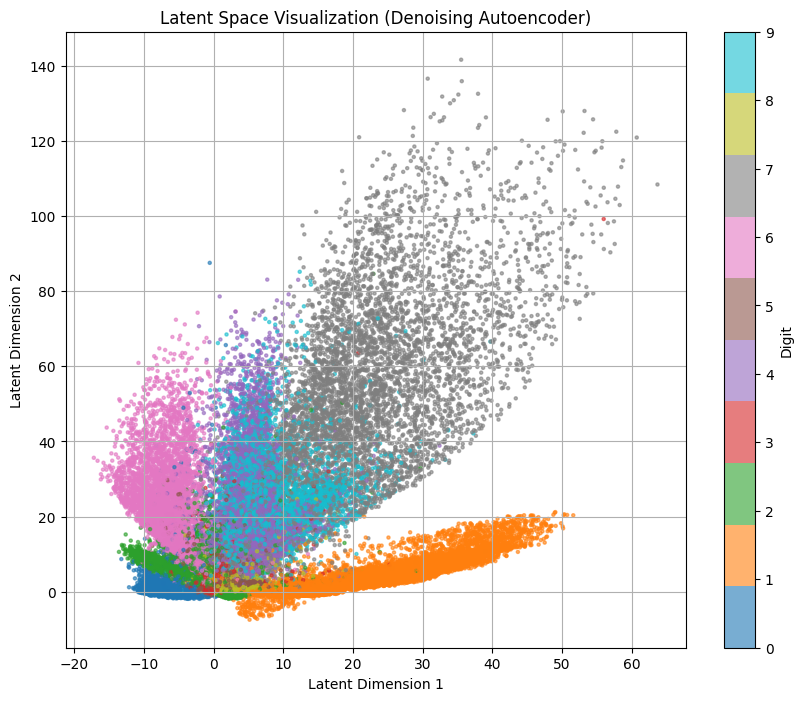

In [11]:
latent_reps, labels = extract_latent_representations(trained_denoising_autoencoder, train_loader)
# Plot the latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_reps[:, 0], latent_reps[:, 1], c=labels, cmap='tab10', alpha=0.6, s=5)
plt.colorbar(scatter, ticks=range(10), label='Digit')
plt.title('Latent Space Visualization (Denoising Autoencoder)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()

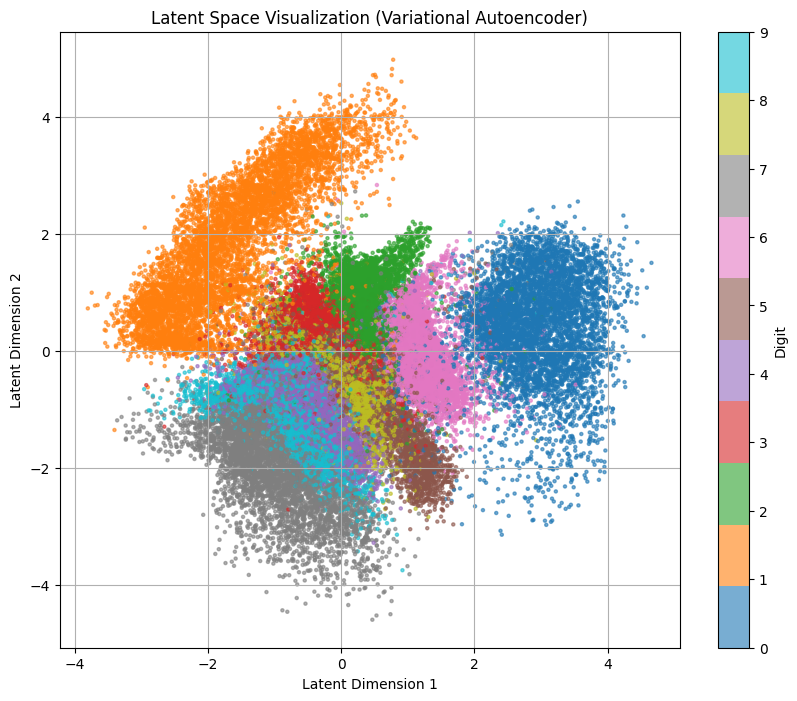

In [12]:
latent_reps, labels = extract_latent_representations(trained_vae, train_loader)
# Plot the latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_reps[:, 0], latent_reps[:, 1], c=labels, cmap='tab10', alpha=0.6, s=5)
plt.colorbar(scatter, ticks=range(10), label='Digit')
plt.title('Latent Space Visualization (Variational Autoencoder)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()

In [13]:
# Function to plot interpolation in latent space
def plot_latent_interpolation(model, n=12, digit_size=28):
    model.eval()
    plt.figure(figsize=(18, 4))

    # Generate latent vectors on the same device as the model
    z1 = torch.randn(1, latent_dim, device=device)
    z2 = torch.randn(1, latent_dim, device=device)

    # Interpolation
    z = torch.stack([z1 + (z2 - z1) * t for t in np.linspace(0, 1, n)])
    z = z.squeeze(0)  # Shape: [n, latent_dim]

    # Decode
    with torch.no_grad():
        if hasattr(model, 'decoder'):
            samples = torch.sigmoid(model.decoder(z)).cpu()
        else:
            # For VAE, use the decode method
            samples = torch.sigmoid(model.decode(z)).cpu()
        samples = samples.view(n, digit_size, digit_size)

    # Plot
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(samples[i].numpy(), cmap='gray')
        plt.axis('off')

    plt.show()


Autoencoder Interpolation:


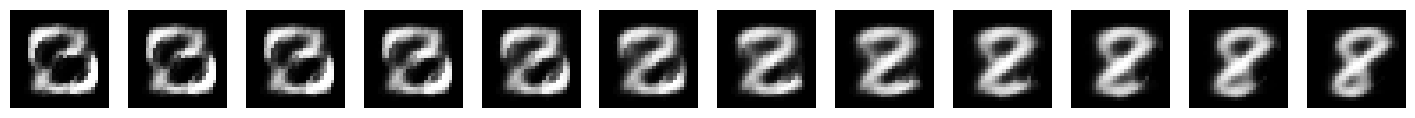


Denoising Autoencoder Interpolation:


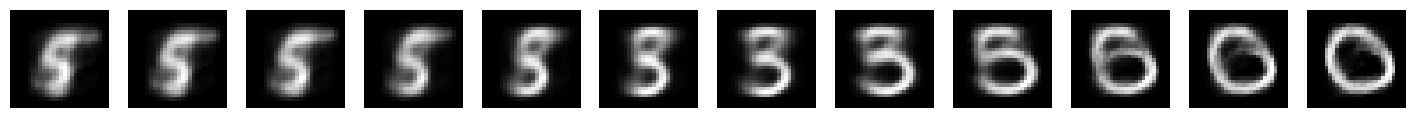


Variational Autoencoder Interpolation:


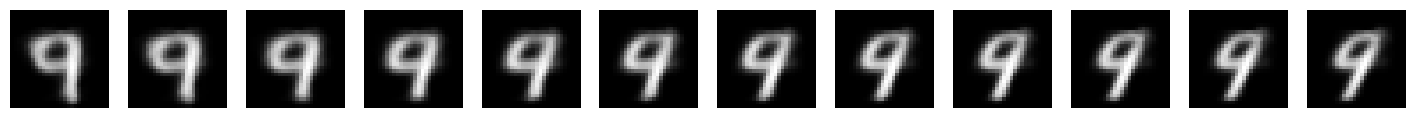

In [14]:
# Plot interpolation for each model for two random points
print("\nAutoencoder Interpolation:")
plot_latent_interpolation(trained_autoencoder)

print("\nDenoising Autoencoder Interpolation:")
plot_latent_interpolation(trained_denoising_autoencoder)

print("\nVariational Autoencoder Interpolation:")
plot_latent_interpolation(trained_vae)

Q1. Create a function to visualize la decoder of the interpolated points in the latent between (0,0) and (1,1), and compare the result of the three models.

In [15]:
# Function to plot interpolation in latent space
def plot_latent_interpolation_from_coordinates(model, z1,z2,n=12, digit_size=28):
    model.eval()
    #z1 and z2 are coordinates in the latent space.
    plt.figure(figsize=(18, 4))
    #TO COMPLETE
    z = torch.stack([z1 + (z2 - z1) * t for t in np.linspace(0, 1, n)], dim=0)
    with torch.no_grad():
        if hasattr(model, 'decoder'):
            decoded_imgs = torch.sigmoid(model.decoder(z)).cpu()
        else:
            decoded_imgs = torch.sigmoid(model.decode(z)).cpu()
        decoded_imgs = decoded_imgs.view(n, digit_size, digit_size)
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(decoded_imgs[i].numpy(), cmap='gray')
        plt.axis('off')

    plt.show()


Autoencoder Interpolation:


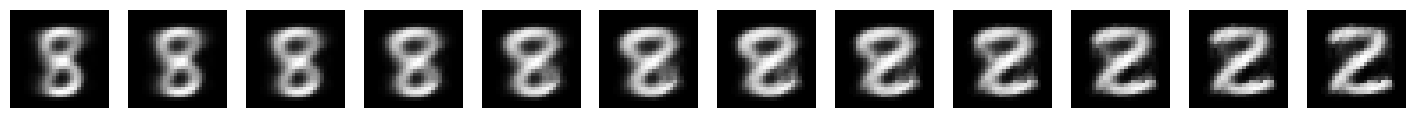


Denoising Autoencoder Interpolation:


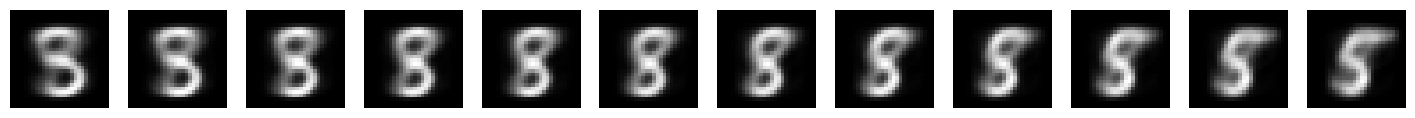


Variational Autoencoder Interpolation:


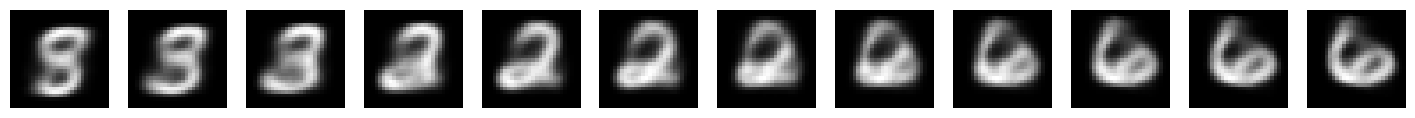

In [16]:
print("\nAutoencoder Interpolation:")
plot_latent_interpolation_from_coordinates(trained_autoencoder,torch.zeros(1,2,device=device),torch.ones(1,2,device=device))

print("\nDenoising Autoencoder Interpolation:")
plot_latent_interpolation_from_coordinates(trained_denoising_autoencoder,torch.zeros(1,2,device=device),torch.ones(1,2,device=device))


print("\nVariational Autoencoder Interpolation:")
plot_latent_interpolation_from_coordinates(trained_vae,torch.zeros(1,2,device=device),torch.ones(1,2,device=device))


As you can see from the above images:

For the Autoencoder:
The images gradually change from one digit (8) into another (2).
The transition is smooth which shows that latent space has some structure but the images are a bit blurry.
This shows that the autoencoder's latent space works well but it's not perfectly smooth. So some points in between may not show clear digits.

For the Denoising Autoencoder:
The interpolation looks more stable and consistent.
Because it was trained to remove noise, its latent space is more robust. Digits still overlap, but the structure is stronger than the normal AE.


For the Variational Autoencoder:
The interpolation looks the most meaningful and continuous. The interpolation is smoother and more continuous.
In VAE latent space, the classes are around 0 so the numbers changes smoother with more diversity.






Q2. Create a function to visualize la interpolatation between to given images and compare the result of the three models.

In [17]:
def plot_interpolation_between_images(model, img1, img2, n=24, digit_size=28):
    model.eval()
    #TO BE COMPLETED
    plt.figure(figsize=(18, 4))

    img1 = img1.view(1, -1).to(device)
    img2 = img2.view(1, -1).to(device)
    with torch.no_grad():
        if hasattr(model, 'encoder'):
            z1 = model.encoder(img1)
            z2 = model.encoder(img2)
        else:
            mu1, _ = model.encode(img1)
            mu2, _ = model.encode(img2)
            z1, z2 = mu1, mu2
    z = torch.stack([z1 + (z2 - z1) * t for t in np.linspace(0, 1, n)], dim=0)
    with torch.no_grad():
        if hasattr(model, 'decoder'):
            decoded_imgs = torch.sigmoid(model.decoder(z)).cpu()
        else:
            decoded_imgs = torch.sigmoid(model.decode(z)).cpu()
        decoded_imgs = decoded_imgs.view(n, digit_size, digit_size)

    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(decoded_imgs[i].numpy(), cmap='gray')
        plt.axis('off')
    plt.show()

In [18]:
# Example usage
img1 = train_dataset[1][0]  # First image
img2 = train_dataset[3][0]  # Second image


Interpolation between two given images:


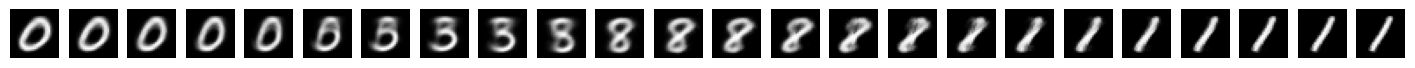

In [19]:
print("Interpolation between two given images:")
plot_interpolation_between_images(trained_autoencoder, img1, img2)

Interpolation between two given images:


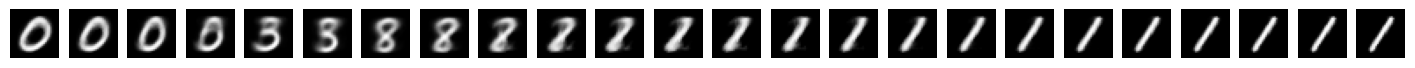

In [20]:
print("Interpolation between two given images:")
plot_interpolation_between_images(trained_denoising_autoencoder, img1, img2)


Interpolation between two given images:


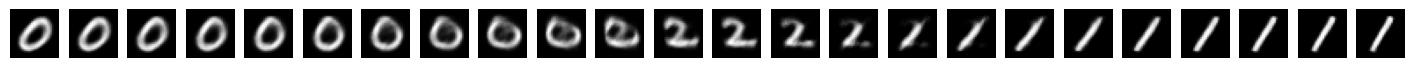

In [21]:
print("Interpolation between two given images:")
plot_interpolation_between_images(trained_vae, img1, img2)

For the Autoencoder:
The transition from 0 to 1 is quite smooth.
You can see the digit slowly changing through several shapes like 0, 5, 3, 8, 2, 1 but some of the middle images look a bit mixed or blurry.
This means the Autoencoder learned a useful representation, but its latent space isn't perfectly smooth.

For Denoising Autoencoder:
The Denoising Autoencoder produces clearer and more stable transitions.
It follows almost the same transformation path (0, 6, 3, 8, 2, 1), but the digits are less noisy and more consistent.
That happens because this model was trained to remove noise, so it learned more robust and stable latent features.
Still, the interpolation isn't completely smooth and it sometimes jumps between digits instead of gradually changing.

For VAE:
It gives the most natural and continuous interpolation.
The digits change very smoothly, with no sudden distortions.
Each intermediate image looks realistic.
This shows that the VAE's latent space is well structured and continuous because of the KL regularization that forces it to follow a normal distribution.

In [22]:
def plot_latent_space_grid(model, n=10, digit_size=28, x_range=(-3, 3), y_range=(-3, 3)):
    model.eval()
    plt.figure(figsize=(15, 15))

    # Create a grid of latent vectors
    x = np.linspace(x_range[0], x_range[1], n)
    y = np.linspace(y_range[0], y_range[1], n)
    z = np.empty((n, n, latent_dim))
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            z[i, j, 0] = xi
            z[i, j, 1] = yj

    # Decode each point in the grid
    with torch.no_grad():
        z_tensor = torch.FloatTensor(z).view(-1, latent_dim).to(device)
        if hasattr(model, 'decoder'):
            samples = torch.sigmoid(model.decoder(z_tensor)).cpu()
        else:
            # For VAE, use the decode method
            samples = torch.sigmoid(model.decode(z_tensor)).cpu()
        samples = samples.view(n, n, digit_size, digit_size)

    # Plot the grid
    for i in range(n):
        for j in range(n):
            plt.subplot(n, n, i * n + j + 1)
            plt.imshow(samples[i, j].numpy(), cmap='gray')
            plt.axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

2D Latent Space Grid:


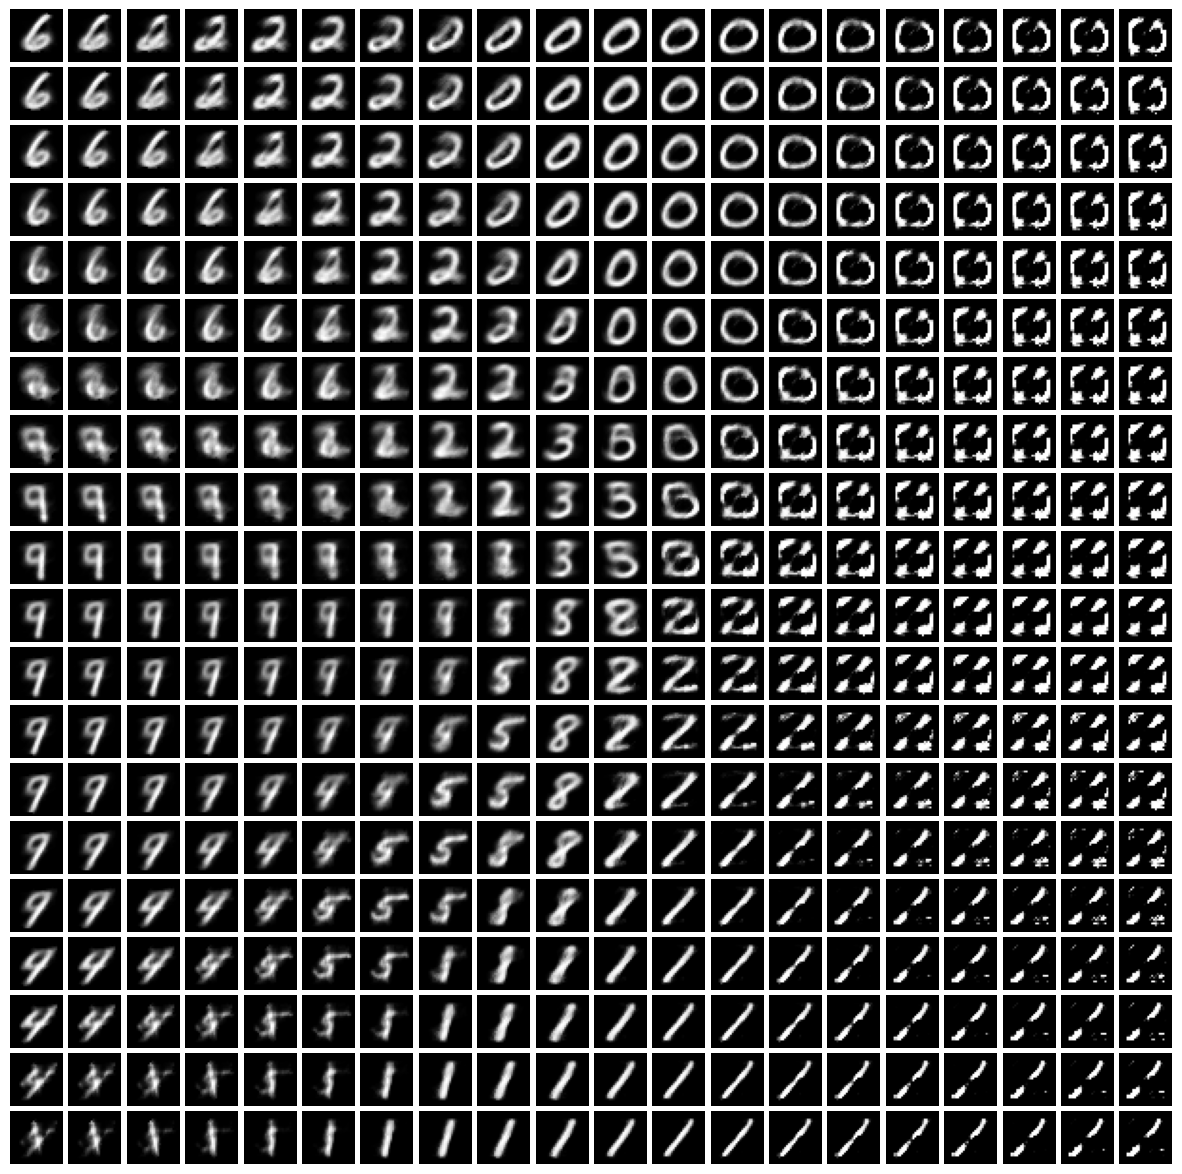

In [23]:
print("2D Latent Space Grid:")
plot_latent_space_grid(trained_autoencoder, n=20, x_range=(-10, 10), y_range=(-10, 10))

2D Latent Space Grid:


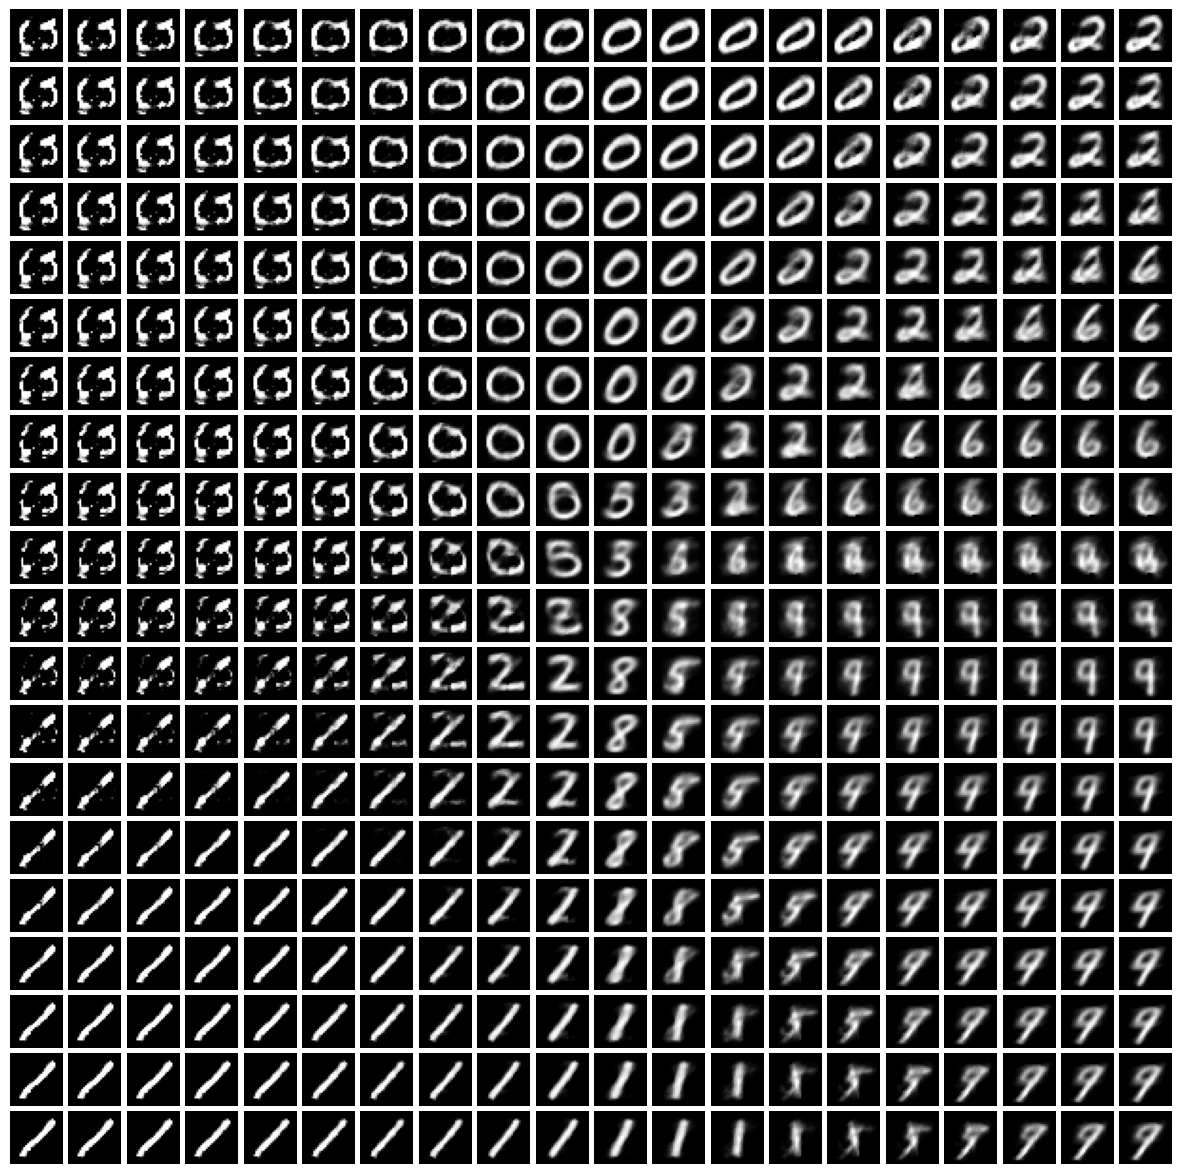

In [24]:
print("2D Latent Space Grid:")
plot_latent_space_grid(trained_denoising_autoencoder, n=20, x_range=(-10, 10), y_range=(-10, 10))

2D Latent Space Grid:


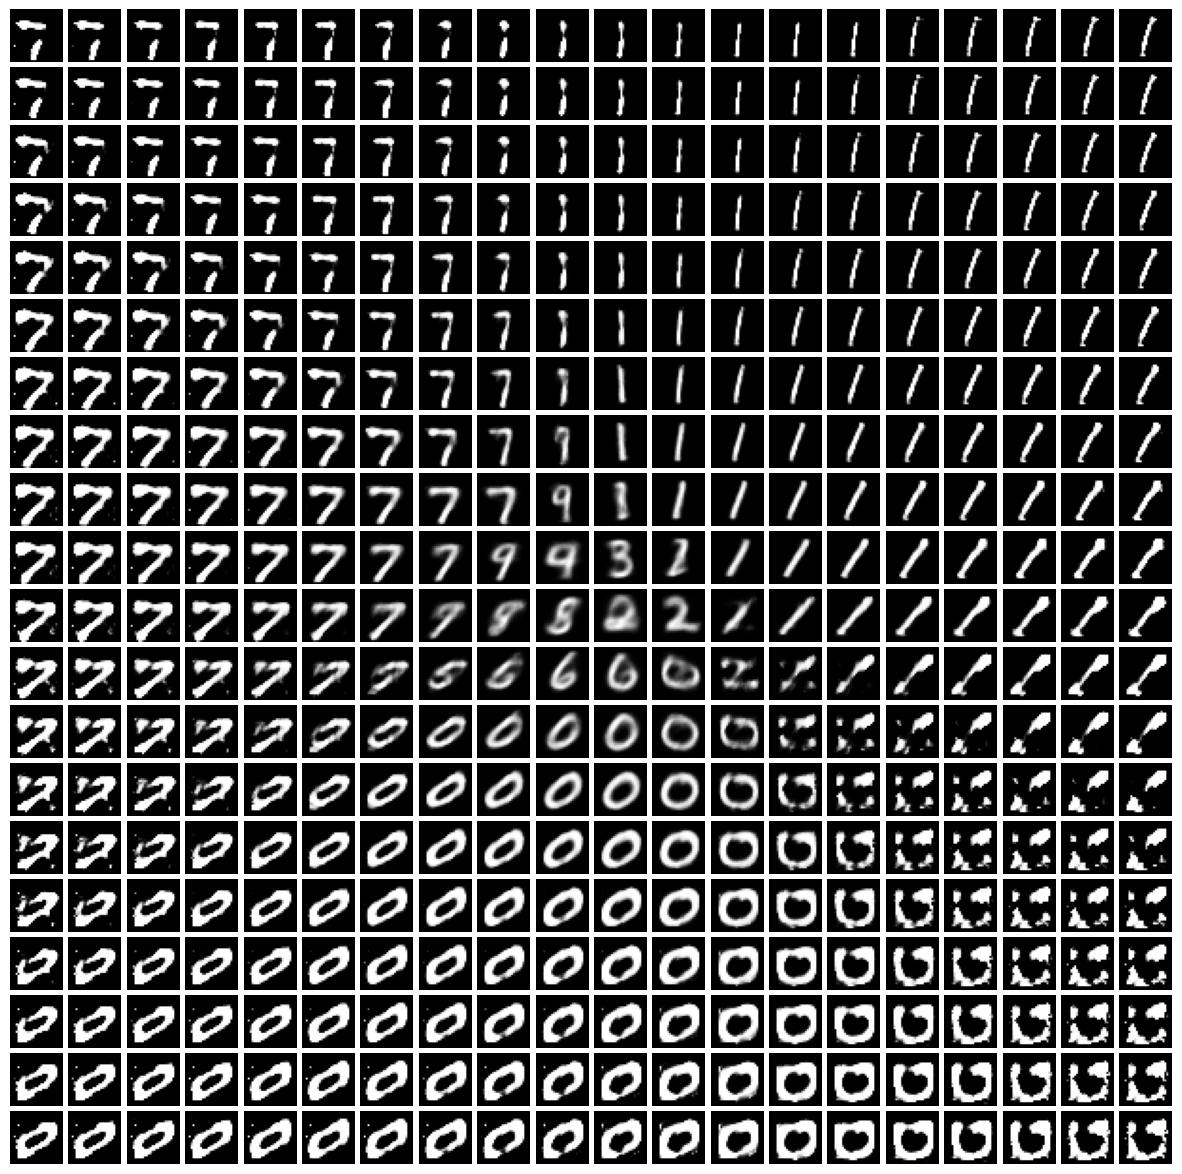

In [25]:
print("2D Latent Space Grid:")
plot_latent_space_grid(trained_vae, n=20, x_range=(-10, 10), y_range=(-10, 10))

Q3. You have the following "new" example:

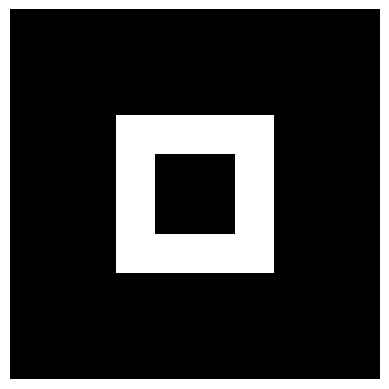

In [26]:
img = torch.zeros(1, 28,28)
img[0,8:20,8:20]=1  # First image
img[0,11:17,11:17]=0  # First image
plt.imshow(img[0],cmap='gray')
plt.axis('off')
plt.show()


a. For the three autoencoders, plot the 2D scatterplot of the projection in latent space for examples in "val_loader" and new example (use a different color).

b. What are the results of reconstructing the three autoencoders for this new example?

c. How can you use an autoencoder to detect whether a new example resembles the objects in the training set?


In [27]:
def scatter_val(model, val_loader, img_new, model_name, is_vae=False):
    model.eval()

    with torch.no_grad():
        x = img_new.to(device).view(1, -1)
        if is_vae:
            _, mu = model.forward_two(x)
            recon = model.decode(mu).sigmoid()
            enc_new = mu
        else:
            recon = model(x)
            if recon.min() < 0 or recon.max() > 1:
                recon = recon.sigmoid()
            _, enc_new = model.forward_two(x)

    recon_img = recon.view(28, 28).detach().cpu().numpy()
    z_new = enc_new[0, :2].detach().cpu().numpy()

    Z = []
    with torch.no_grad():
        for imgs, _ in val_loader:
            flat = imgs.to(device).view(imgs.size(0), -1)
            _, enc = model.forward_two(flat)
            Z.append(enc[:, :2].detach().cpu().numpy())
    Z = np.concatenate(Z, axis=0)

    plt.figure(figsize=(5, 7))
    plt.subplot(2, 1, 1)
    plt.imshow(recon_img, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 1, 2)
    plt.scatter(Z[:, 0], Z[:, 1], s=8, alpha=0.35, label='validation images')
    plt.scatter([z_new[0]], [z_new[1]], c='red', s=60, label='new image')
    plt.xlabel("Latent dimension 1")
    plt.ylabel("Latent dimension 2")
    plt.legend()
    plt.show()


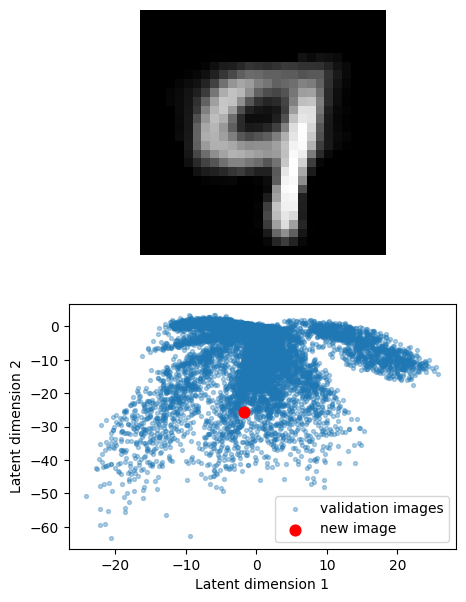

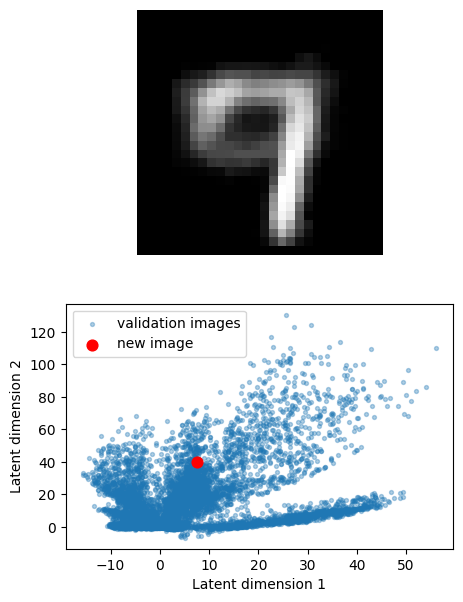

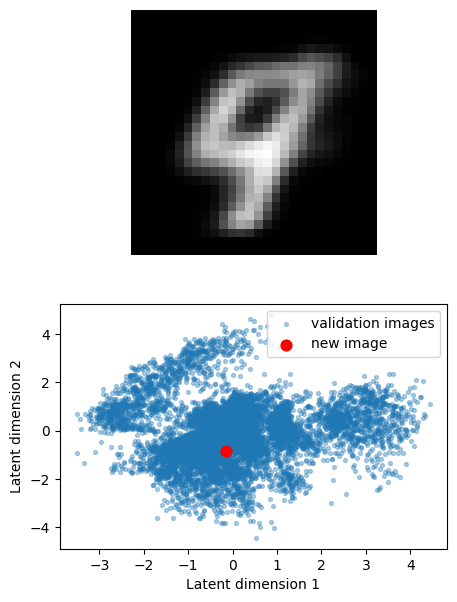

In [28]:
scatter_val(trained_autoencoder, val_loader, img, "Autoencoder", is_vae=False)
scatter_val(trained_denoising_autoencoder, val_loader, img, "Denoising Autoencoder", is_vae=False)
scatter_val(trained_vae, val_loader, img, "Variational Autoencoder", is_vae=True)

a) Shown in the above cell.

b)We gave a new image that doesn't look like any MNIST digit.
After passing it through each autoencoder:

In Autoencoder:
The reconstruction looks like a digit 9.
This means the model forced the input to look like something from the digit space it already knows.
It can't understand the square shape so it transforms it into the closest familiar pattern.

In Denoising Autoencoder:
The output is also close to a 9 slightly blurrier.
Because it was trained to remove noise and reconstruct clean digits, it tries to denoise the square input into something digit-like.
It doesn't preserve the square shape at all. It just maps it to what it knows best.

In Variational Autoencoder:
The reconstruction is again similar to a 9 but more continuous.
VAE learns a more structured latent space so any point in that space will decode into a valid digit.
Even if the input is weird the VAE pulls it back into the distribution of normal digits.


c)We can use reconstruction error or latent-space distance.

In latent space method we encode the image to its latent vector.
Compare its position (the red dot) to all training points (blue dots).
If it's far away from most of the points then it's not similar to the training data.
In our scatter plots, the red dot is roughly at the edge or outside of the main cluster which shows it's not a digit-like example.

In reconstruction error method, we pass the new image through the autoencoder.
Compute how different the reconstructed image is from the original one using mean squared error.
If the reconstruction error is small, it means the model knows this type of image and it's similar to the training set. But if the error is large, it means the model couldn't rebuild it well and it's a outlier image.
In our case, the square image probably has a high reconstruction error, because none of the autoencoders can reproduce it properly.

Q4. Write a function to generate 10 new examples for each autoencoder?  

In [ ]:
#from sklearn.neighbors import KernelDensity
#kde = KernelDensity().fit(latent_reps)  # fit kde
#z_sampled = kde.sample(10)

In [31]:
from sklearn.neighbors import KernelDensity

def generate_new_examples(model, latent_reps, n_samples=10, digit_size=28, is_vae=False):

    model.eval()

    kde = KernelDensity().fit(latent_reps)
    z_sampled = kde.sample(n_samples)

    z_tensor = torch.FloatTensor(z_sampled).to(device)

    with torch.no_grad():
        if hasattr(model, 'decoder'):
            generated = torch.sigmoid(model.decoder(z_tensor)).cpu()
        else:
            generated = torch.sigmoid(model.decode(z_tensor)).cpu()
        generated = generated.view(n_samples, digit_size, digit_size)

    plt.figure(figsize=(12, 2))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(generated[i].numpy(), cmap='gray')
        plt.axis('off')
    plt.show()

Autoencoder: Generated Samples:


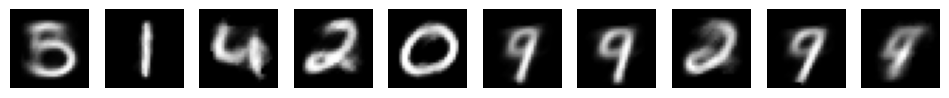

Denoising Autoencoder: Generated Samples:


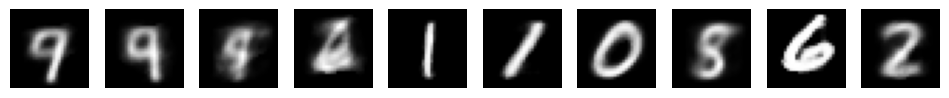

Variational Autoencoder: Generated Samples:


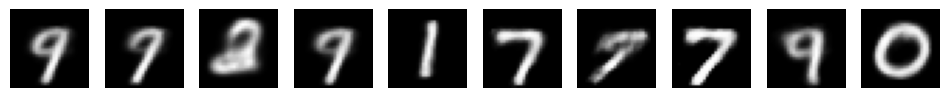

In [33]:
latent_auto, _ = extract_latent_representations(trained_autoencoder, val_loader)
latent_denoising, _ = extract_latent_representations(trained_denoising_autoencoder, val_loader)
latent_vae, _ = extract_latent_representations(trained_vae, val_loader)

print("Autoencoder: Generated Samples:")
generate_new_examples(trained_autoencoder, latent_auto, n_samples=10, is_vae=False)

print("Denoising Autoencoder: Generated Samples:")
generate_new_examples(trained_denoising_autoencoder, latent_denoising, n_samples=10, is_vae=False)

print("Variational Autoencoder: Generated Samples:")
generate_new_examples(trained_vae, latent_vae, n_samples=10, is_vae=True)

Q5. Write a function to generate 10 new examples of the class 0 for each autoencoder?

In [36]:
def generate_class_examples(model, latent_reps, labels, target_class=0, n_samples=10, digit_size=28, is_vae=False):

    model.eval()

    latent_class = latent_reps[labels == target_class]
    kde = KernelDensity().fit(latent_class)
    z_sampled = kde.sample(n_samples)
    z_tensor = torch.FloatTensor(z_sampled).to(device)

    with torch.no_grad():
        if hasattr(model, 'decoder'):
            generated = torch.sigmoid(model.decoder(z_tensor)).cpu()
        else:
            generated = torch.sigmoid(model.decode(z_tensor)).cpu()
        generated = generated.view(n_samples, digit_size, digit_size)

    plt.figure(figsize=(12, 2))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(generated[i].numpy(), cmap='gray')
        plt.axis('off')
    plt.show()

Autoencoder:


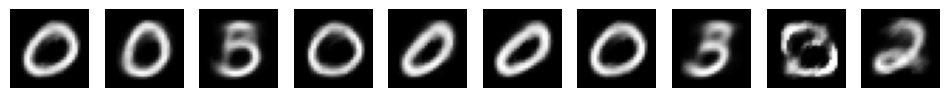

Denoising Autoencoder:


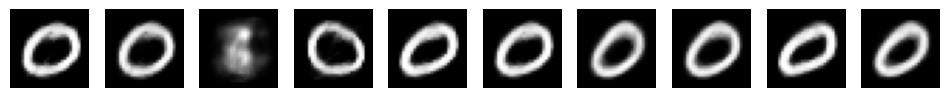

Variational Autoencoder:


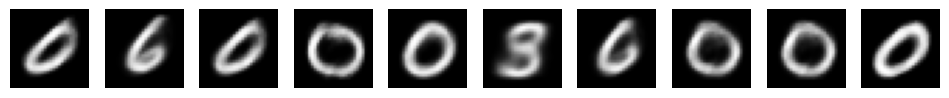

In [37]:
latent_auto, labels_auto = extract_latent_representations(trained_autoencoder, val_loader)
latent_denoising, labels_denoising = extract_latent_representations(trained_denoising_autoencoder, val_loader)
latent_vae, labels_vae = extract_latent_representations(trained_vae, val_loader)

print("Autoencoder:")
generate_class_examples(trained_autoencoder, latent_auto, labels_auto, target_class=0, is_vae=False)

print("Denoising Autoencoder:")
generate_class_examples(trained_denoising_autoencoder, latent_denoising, labels_denoising, target_class=0, is_vae=False)

print("Variational Autoencoder:")
generate_class_examples(trained_vae, latent_vae, labels_vae, target_class=0, is_vae=True)


Q6. Autoencoders vs. PCA:

Compare the reconstructions and latent spaces of an autoencoder and PCA on the same dataset.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

Discuss the advantages and limitations of each method.

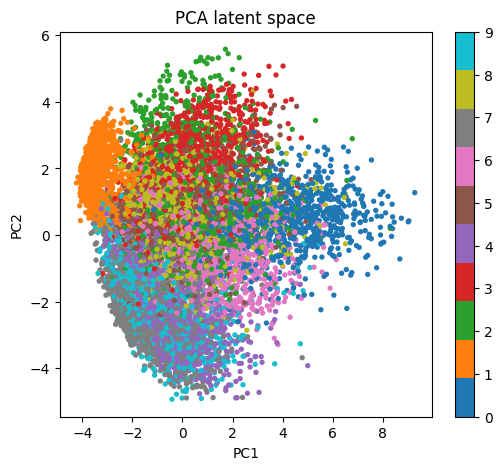

In [40]:
from sklearn.decomposition import PCA

all_images = []
all_labels = []
for imgs, lbls in val_loader:
    all_images.append(imgs.view(imgs.size(0), -1).numpy())
    all_labels.append(lbls.numpy())

all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

latent_dim = 2
pca = PCA(n_components=latent_dim)
Z_pca = pca.fit_transform(all_images)
recon_pca = pca.inverse_transform(Z_pca)

plt.figure(figsize=(6,5))
plt.scatter(Z_pca[:, 0], Z_pca[:, 1], c=all_labels, cmap='tab10', s=8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA latent space")
plt.colorbar()
plt.show()


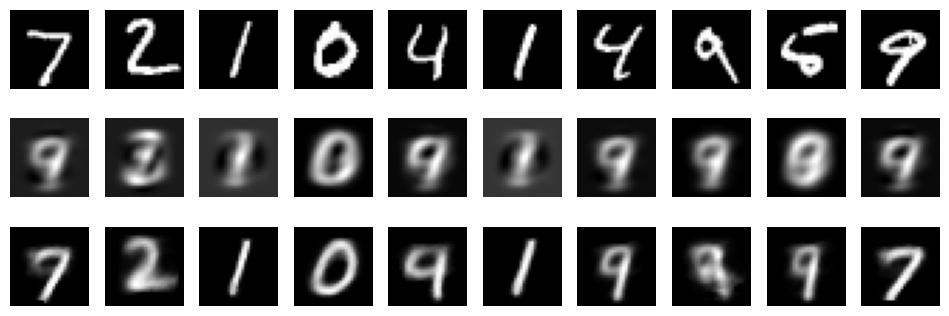

In [41]:
all_images = []
for imgs, _ in val_loader:
    all_images.append(imgs.view(imgs.size(0), -1).numpy())
all_images = np.concatenate(all_images, axis=0)

trained_autoencoder.eval()
with torch.no_grad():
    imgs_tensor = torch.tensor(all_images, dtype=torch.float32).to(device)
    recon_auto = trained_autoencoder(imgs_tensor).cpu().numpy()


n = 10
plt.figure(figsize=(12, 4))

for i in range(n):
    # Original
    plt.subplot(3, n, i + 1)
    plt.imshow(all_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("Original")

    # PCA reconstruction
    plt.subplot(3, n, n + i + 1)
    plt.imshow(recon_pca[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("PCA")

    # Autoencoder reconstruction
    plt.subplot(3, n, 2 * n + i + 1)
    plt.imshow(recon_auto[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("Autoencoder")

plt.show()


Both models compress images into a 2D latent space and then reconstruct them back to 28*28 digits.

Latent Space:

In the PCA latent space, the points are distributed in an overlapping way and different digits are not well separated.
This happens because PCA only captures linear directions of highest variance.

In contrast, the Autoencoder's latent space is more organized and similar digits are grouped together more clearly.
Since the Autoencoder learns non-linear transformations, it can separate the digit classes better.

Reconstructions:

PCA reconstructions look blurred and average-like. They capture the rough outline of the digits but lose many details such as stroke thickness and small curves.
PCA can only rebuild what can be represented by linear combinations of its main components.

Autoencoder reconstructions are sharper and closer to the original digits.
The model learns a non-linear mapping, so it can represent more complex patterns and curved shapes.

Advantages and Limitations of Each Method:

- PCA:

  - Advantages:

      Very fast and easy to use. No training is needed.

      Gives interpretable components that show the main directions of variance in the data.

      Works well when the data structure is mostly linear.

  - Limitations:

      Can only capture linear relationships between pixels.

      Loses fine details in images. Reconstructions look blurred and average-like.

      The latent space does not clearly separate different digit classes.

- Autoencoder:

  - Advantages:

      Can learn non-linear mappings using neural network layers.

      Produces much sharper and more realistic reconstructions.

      Learns richer and more meaningful latent representations and digits of the same class often cluster together.

  - Limitations:

      Requires training, which takes more time and resources.

      The latent dimensions are not directly interpretable.

      Sensitive to architecture and hyperparameters and can overfit or underperform if not tuned properly.


The general formula for the KL divergence between two Gaussian distributions $N(\boldsymbol{\mu}_1,\boldsymbol{\Sigma}_1)$ and $N(\boldsymbol{\mu}_2,\boldsymbol{\Sigma}_2)$ is:

$   D_{\text{KL}}(q \parallel p) = \frac{1}{2} \left( \text{tr}(\boldsymbol{\Sigma}_1^{-1} \boldsymbol{\Sigma}_0) + (\boldsymbol{\mu}_1 - \boldsymbol{\mu}_0)^T \boldsymbol{\Sigma}_1^{-1} (\boldsymbol{\mu}_1 - \boldsymbol{\mu}_0) - k + \ln \left( \frac{\det(\boldsymbol{\Sigma}_1)}{\det(\boldsymbol{\Sigma}_0)} \right) \right)$ where $\text{tr}$ is the trace and $\det$ the determinant.

Q7. Compute the KL-divergence between two 1D Gaussian distributions step by step. Can you interpretate each one of the term? What happens if the two distribution have the same varianza?


### Answer:

Let  
- $q(x) = N(\mu_0, \sigma_0^2)$ with covariance $\Sigma_0 = \sigma_0^2$,  
- $p(x) = N(\mu_1, \sigma_1^2)$ with covariance $\Sigma_1 = \sigma_1^2$.

In 1D:  
- $k = 1$  
- $\Sigma_1^{-1} = 1 / \sigma_1^2$  
- $\det(\Sigma_i) = \sigma_i^2$ (because a 1D covariance matrix is just the scalar variance)  
- $\text{tr}(a) = a$ for any scalar $a$



Start from:

$$
D_{\text{KL}}(q \parallel p)
= \frac{1}{2}
\left(
\text{tr}(\Sigma_1^{-1} \Sigma_0)
+ (\mu_1 - \mu_0)^T \Sigma_1^{-1} (\mu_1 - \mu_0)
- 1
+ \ln \frac{\det(\Sigma_1)}{\det(\Sigma_0)}
\right)
$$

Compute each term:

1. $\text{tr}(\Sigma_1^{-1} \Sigma_0) = \sigma_0^2 / \sigma_1^2$  
2. $(\mu_1 - \mu_0)^T \Sigma_1^{-1} (\mu_1 - \mu_0) = (\mu_1 - \mu_0)^2 / \sigma_1^2$  
3. $-k = -1$  
4. $\ln\left(\frac{\det(\Sigma_1)}{\det(\Sigma_0)}\right) = \ln\left(\frac{\sigma_1^2}{\sigma_0^2}\right)$  

Combine everything:

$$
D_{\text{KL}}(q \parallel p)
= \frac{1}{2}
\left[
\frac{\sigma_0^2}{\sigma_1^2}
+ \frac{(\mu_1 - \mu_0)^2}{\sigma_1^2}
- 1
+ \ln\left(\frac{\sigma_1^2}{\sigma_0^2}\right)
\right]
$$


- $\frac{\sigma_0^2}{\sigma_1^2}$ is spread mismatch  
  Measures how much the variance of $q$ differs from the variance of $p$.

- $\frac{(\mu_1 - \mu_0)^2}{\sigma_1^2}$ is mean mismatch  
  Measures how far the two means are apart, scaled by $p$'s variance.

- $-1$ is dimensional correction  
  Makes the KL divergence equal to zero when the two Gaussians are identical.

- $\ln\left(\frac{\sigma_1^2}{\sigma_0^2}\right)$ is Log-variance term  
  Penalizes the difference in scale between the two variances.

> $D_{\text{KL}}(q \parallel p) \neq D_{\text{KL}}(p \parallel q)$ because it is not symmetric.


----
Same variance:

If the two distributions have the same variance $\sigma_0^2 = \sigma_1^2 = \sigma^2$:

$$
D_{\text{KL}}(q \parallel p)
= \frac{(\mu_1 - \mu_0)^2}{2\sigma^2}
$$

That means the divergence depends only on the difference of the means.  
If $\mu_1 = \mu_0$, then $D_{\text{KL}} = 0$.



Q8. Compute the KL-divergence for two Gaussian distribution with diagonal covariance matrix.


### Answer:
Let both covariance matrices be diagonal:

$$
\boldsymbol{\Sigma}_0 = \text{diag}(\sigma_{0,1}^2, \sigma_{0,2}^2, \ldots, \sigma_{0,k}^2)
\quad \text{and} \quad
\boldsymbol{\Sigma}_1 = \text{diag}(\sigma_{1,1}^2, \sigma_{1,2}^2, \ldots, \sigma_{1,k}^2)
$$

Then:
- $\boldsymbol{\Sigma}_1^{-1} = \text{diag}(1/\sigma_{1,1}^2, 1/\sigma_{1,2}^2, \ldots, 1/\sigma_{1,k}^2)$  
- $\det(\boldsymbol{\Sigma}_i) = \prod_{j=1}^k \sigma_{i,j}^2$  
- $\text{tr}(\boldsymbol{\Sigma}_1^{-1} \boldsymbol{\Sigma}_0) = \sum_{j=1}^k \frac{\sigma_{0,j}^2}{\sigma_{1,j}^2}$

Substituting these expressions gives:

$$
D_{\text{KL}}(q \parallel p)
= \frac{1}{2} \left[
\sum_{j=1}^k
\frac{\sigma_{0,j}^2}{\sigma_{1,j}^2}
+ \sum_{j=1}^k
\frac{(\mu_{1,j} - \mu_{0,j})^2}{\sigma_{1,j}^2}
- k
+ \ln \frac{\prod_{j=1}^k \sigma_{1,j}^2}{\prod_{j=1}^k \sigma_{0,j}^2}
\right]
$$

Simplify the log-determinant ratio using properties of logs:

$$
\ln \frac{\prod_{j=1}^k \sigma_{1,j}^2}{\prod_{j=1}^k \sigma_{0,j}^2}
= \sum_{j=1}^k \ln \frac{\sigma_{1,j}^2}{\sigma_{0,j}^2}
$$

So the KL-divergence becomes:

$$
D_{\text{KL}}(q \parallel p)
= \frac{1}{2} \sum_{j=1}^k
\left[
\frac{\sigma_{0,j}^2}{\sigma_{1,j}^2}
+ \frac{(\mu_{1,j} - \mu_{0,j})^2}{\sigma_{1,j}^2}
- 1
+ \ln \left( \frac{\sigma_{1,j}^2}{\sigma_{0,j}^2} \right)
\right]
$$


For each dimension $j$:

- $\frac{\sigma_{0,j}^2}{\sigma_{1,j}^2}$ is how much the variance of $q$ differs from $p$ in that direction.  
- $\frac{(\mu_{1,j} - \mu_{0,j})^2}{\sigma_{1,j}^2}$ shows how far the means are apart in that dimension, scaled by $p$'s variance.  
- $-1$ is dimension correction term, ensures zero divergence when distributions are identical.  
- $\ln \frac{\sigma_{1,j}^2}{\sigma_{0,j}^2}$ is penalty for scale difference between the two.

Each dimension contributes independently. So the total KL divergence is a sum across all dimensions.

---

If $\sigma_{0,j}^2 = \sigma_{1,j}^2 = \sigma^2$ for all $j$:

$$
D_{\text{KL}}(q \parallel p)
= \frac{1}{2\sigma^2} \sum_{j=1}^k (\mu_{1,j} - \mu_{0,j})^2
$$

That is, the KL-divergence reduces to a scaled squared Euclidean distance between the mean vectors.
